# **Análisis del valor de las criptomonedas con series de tiempo**




---


### **Integrantes:**

*Carlos Daniel Barrera Manrique - 2162061*


*Martha Eliana Arenas Márquez   - 2162042*

# **Objetivo:**

### Conocer el día más probable que sea rentable comprar o vender criptomonedas bitcoin.

Basándonos en los datos obtenidos durante 6 años, queremos realizar un  modelo capaz de simular el comportamiento del precio del bitcoin, de tal forma que podamos predecir los días donde sea rentable comprar o vender bitcoins, esto para aplicarlo en metodologías como trading.


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import statsmodels.api as sm
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
pd.__version__
g= ! pip install seaborn
p = !pip install pyramid-arima

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Dataset traido desde kaggle:**

https://www.kaggle.com/philmohun/cryptocurrency-financial-data

In [4]:
d= pd.read_csv("/content/drive/My Drive/Octavo semestre/Simulacion/Proyecto/consolidated_coin_data.csv")
d.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,tezos,"Dec 04, 2019",1.29,1.32,1.25,1.25,"46,048,752","824,588,509"
1,tezos,"Dec 03, 2019",1.24,1.32,1.21,1.29,"41,462,224","853,213,342"
2,tezos,"Dec 02, 2019",1.25,1.26,1.20,1.24,"27,574,097","817,872,179"
3,tezos,"Dec 01, 2019",1.33,1.34,1.25,1.25,"24,127,567","828,296,390"
4,tezos,"Nov 30, 2019",1.31,1.37,1.31,1.33,"28,706,667","879,181,680"


# **Tratamiento de datos**

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28944 entries, 0 to 28943
Data columns (total 8 columns):
Currency      28944 non-null object
Date          28944 non-null object
Open          28944 non-null object
High          28944 non-null object
Low           28944 non-null object
Close         28944 non-null object
Volume        28944 non-null object
Market Cap    28944 non-null object
dtypes: object(8)
memory usage: 1.8+ MB


In [6]:
d=d[d.Currency=="bitcoin"]
d.Open=[col.replace(",","") for col in d.Open]
d["Open"]=d["Open"].astype(np.float64)
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 7236 to 9647
Data columns (total 8 columns):
Currency      2412 non-null object
Date          2412 non-null object
Open          2412 non-null float64
High          2412 non-null object
Low           2412 non-null object
Close         2412 non-null object
Volume        2412 non-null object
Market Cap    2412 non-null object
dtypes: float64(1), object(7)
memory usage: 169.6+ KB


In [7]:
d.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
7236,bitcoin,"Dec 04, 2019",7320.13,"7,539.78","7,170.92","7,252.03","21,664,240,918","131,143,073,943"
7237,bitcoin,"Dec 03, 2019",7323.98,"7,418.86","7,229.36","7,320.15","14,797,485,769","132,359,942,301"
7238,bitcoin,"Dec 02, 2019",7424.04,"7,474.82","7,233.40","7,321.99","17,082,040,706","132,378,982,377"
7239,bitcoin,"Dec 01, 2019",7571.62,"7,571.62","7,291.34","7,424.29","18,720,708,479","134,215,145,410"
7240,bitcoin,"Nov 30, 2019",7764.06,"7,836.10","7,515.85","7,569.63","17,158,194,786","136,829,391,049"


In [0]:
from datetime import datetime
d['Date'] = pd.to_datetime(d['Date'])
d.set_index('Date', inplace=True)
ts = d['Open']
ts=ts.sort_index()

# **Análisis exploratorio de la serie de tiempo**

## Dividimos el dataset en train y test para evaluar la predicción

In [0]:
#dividir en train y test
train = ts[:int(0.8*(len(ts)))]
test = ts[int(0.8*(len(ts))):]


## Plot de train y test

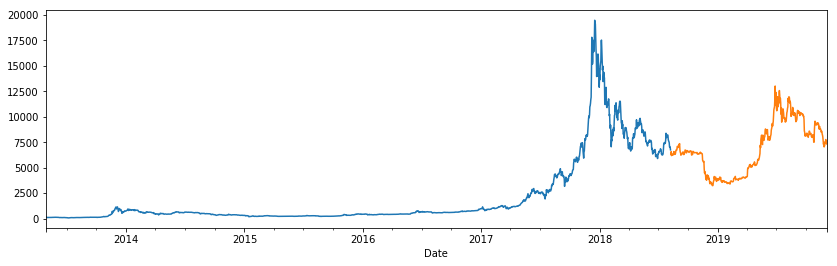

In [17]:
plt.figure(figsize=(14,4))

train.plot()
test.plot()


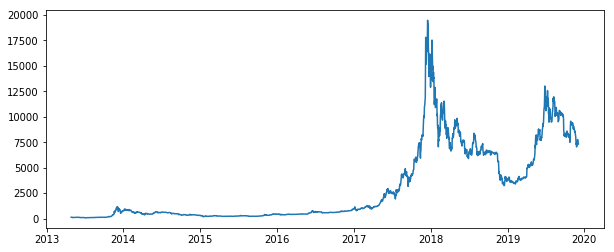

In [11]:
plt.figure(figsize=(10,4))
plt.plot(ts)

In [0]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    ## Prueba de Dickey-fuller: esta es una de las pruebas estadísticas para verificar la estacionariedad. 
    #Primero consideramos la hipótesis nula: la serie temporal no es estacionaria. 
    #El resultado del resto contendrá la estadística de prueba y el valor crítico para diferentes niveles de 
    #confianza. La idea es tener estadísticas de prueba inferiores al valor crítico, en este caso podemos rechazar 
    #la hipótesis nula y decir que esta serie de tiempo es estacionaria
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# **Test de estacionariedad**

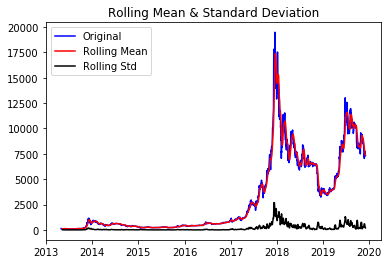

Results of Dickey-Fuller Test:
Test Statistic                   -1.603153
p-value                           0.482009
#Lags Used                       27.000000
Number of Observations Used    2384.000000
Critical Value (5%)              -2.862753
Critical Value (1%)              -3.433096
Critical Value (10%)             -2.567416
dtype: float64


In [0]:

test_stationarity(ts)

**Conclusión:** La serie **No** es **Estacionaria** ya que el p_value es mayor que el alpha con un 95% de confianza. Por lo tanto la hipotesis nula se acepta, la cual dice que la serie es no estacionaria.

# **Aplicación Shift a la serie de tiempo** 

Reducimos la tendencia volviendo la serie a escala logaritmica

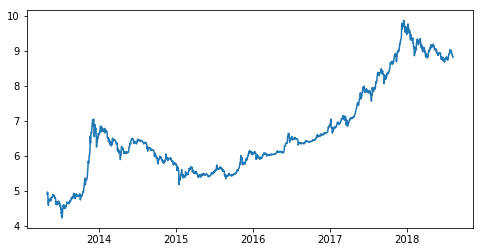

In [0]:
ts_log = np.log(train)
plt.figure(figsize=(8,4))
plt.plot(ts_log)

# **Time Shift Transformation**

# Diferenciacion tendencia y estacionariedad

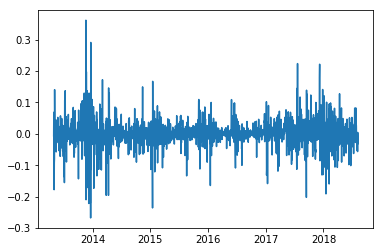

In [0]:
ts_log_diff_shifting = ts_log - ts_log.shift()
plt.plot(ts_log_diff_shifting)

##**Prueba estacionalidad con Time Shift Transformation**

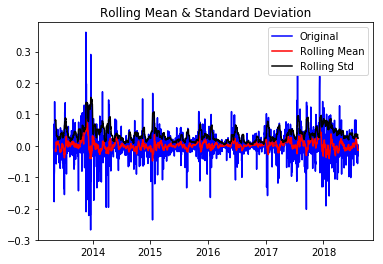

Results of Dickey-Fuller Test:
Test Statistic                -7.925259e+00
p-value                        3.633157e-12
#Lags Used                     2.200000e+01
Number of Observations Used    1.905000e+03
Critical Value (5%)           -2.863058e+00
Critical Value (1%)           -3.433787e+00
Critical Value (10%)          -2.567578e+00
dtype: float64


In [0]:
ts_log_diff_shifting.dropna(inplace=True)
test_stationarity(ts_log_diff_shifting)

**Conclusión:** La serie es **Estacionaria** ya que el P_value es menor que el alpha de (0.05).

# **Forecasting a Time Series**

## **ACF & PACF**

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


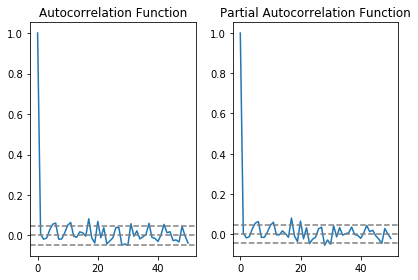

In [0]:
#ACF & PACF plots

lag_acf = acf(ts_log_diff_shifting, nlags=50)
lag_pacf = pacf(ts_log_diff_shifting, nlags=50, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 


In [0]:
lag_acf = acf(ts_log_diff_shifting, nlags=20)
lag_pacf = pacf(ts_log_diff_shifting, nlags=20, method='ols')
lag_pacf

array([ 1.        ,  0.00572913, -0.01839493, -0.01219763,  0.02675622,
        0.05525769,  0.0626874 , -0.0160067 , -0.01508197,  0.01046749,
        0.04432177,  0.05964714, -0.00313451, -0.00309281,  0.01678148,
        0.00260914, -0.01494797,  0.07994411, -0.00868767, -0.03620378,
        0.0651462 ])

In [0]:
lag_acf

array([ 1.        ,  0.00572754, -0.01835535, -0.01241401,  0.02686337,
        0.05568952,  0.06158065, -0.0181934 , -0.01716757,  0.01297125,
        0.05092737,  0.06434501, -0.00391853, -0.00853147,  0.01806156,
        0.01277353, -0.00347832,  0.08268917, -0.01218376, -0.03652465,
        0.06963788])

# **ARIMA**

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Plotting AR model


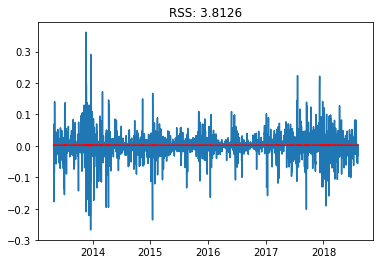

In [0]:
model = ARIMA(ts_log, order=(0,1,1))
results_ARIMA = model.fit()
plt.plot(ts_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts_log_diff_shifting)**2))
print('Plotting AR model')

**fitted values**

In [0]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2013-04-29    0.002028
2013-04-30    0.001978
2013-05-01    0.002424
2013-05-02    0.001803
2013-05-03    0.000961
dtype: float64


**fitted values cumsum**

In [0]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2013-04-29    0.002028
2013-04-30    0.004005
2013-05-01    0.006429
2013-05-02    0.008232
2013-05-03    0.009193
dtype: float64


Se agrega los fitted values cumsum a la serie de tiempo

In [0]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
2013-04-28    4.907495
2013-04-29    4.909522
2013-04-30    4.911500
2013-05-01    4.913924
2013-05-02    4.915727
dtype: float64

Se convierten los valores a escala exponencial

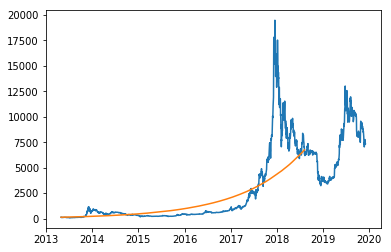

In [0]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)

## Conclusión:
El modelo no se ajusta al problema, ya que predijo el valor del bitcoin de una forma exponencial.


In [0]:
predictions_ARIMA_log.shape

(1929,)

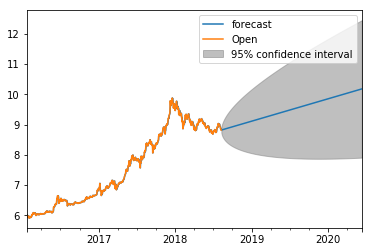

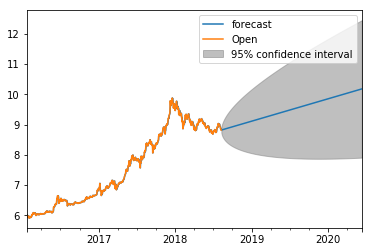

In [0]:
results_ARIMA.plot_predict(1000,2600) 

# **Otros métodos**

# **Autoarima**



In [0]:
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
print(model.aic())

/usr/local/lib/python2.7/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=26547.543, BIC=26580.929, Fit time=1.909 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=26572.169, BIC=26583.297, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=26562.126, BIC=26578.819, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=26561.193, BIC=26577.886, Fit time=0.225 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=26562.649, BIC=26590.470, Fit time=0.495 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=26549.169, BIC=26588.119, Fit time=3.875 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=26562.211, BIC=26590.032, Fit time=0.414 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=26490.840, BIC=26529.790, Fit time=3.982 seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=26520.763, BIC=26570.841, Fit time=4.813 seconds
Fit ARIMA: order=(1

In [0]:
model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [0]:
autoarima1 = model.predict(n_periods=len(test))
autoarima = pd.DataFrame(autoarima1,index = test.index,columns=['Autoarima'])



---





 *   **Forecast**




In [0]:
autoarima.tail()

,Autoarima
Date,
2019-11-30,7111.146979
2019-12-01,7111.922253
2019-12-02,7112.697548
2019-12-03,7113.472829
2019-12-04,7114.248113


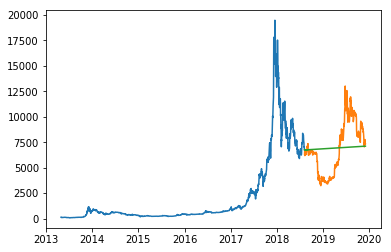

In [0]:
#plot las predicciones
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(autoarima, label='Prediction')
plt.show()



---






*  **MSE**




In [0]:
#calcular mse
from math import sqrt
from sklearn.metrics import mean_squared_error

mse = sqrt(mean_squared_error(test,autoarima))
print(mse)

2448.04531387


# **Exponential Smoothing - Holt Winter**

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
holt_wint1 = fit1.forecast(len(test))


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [0]:
holt_wint = pd.Series(holt_wint1,index=test.index)

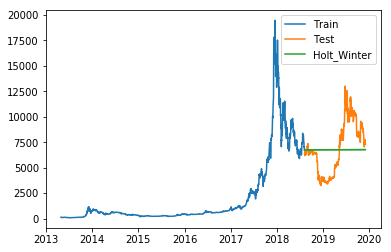

In [0]:
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(holt_wint, label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [0]:
holt_wint.tail()

Date
2019-11-30    6759.373942
2019-12-01    6772.560317
2019-12-02    6775.938354
2019-12-03    6786.689516
2019-12-04    6777.509919
dtype: float64



---





*   **MSE**



In [0]:
rms = sqrt(mean_squared_error(test,holt_wint))
print(rms)

2510.63266806


# **Sarimax**

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


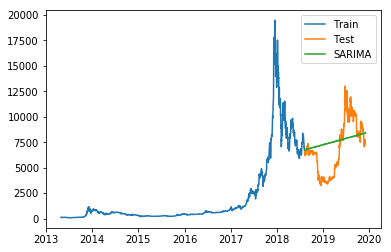

In [0]:
sarima = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
sarima1 = fit1.forecast(steps=len(test))
sarima = pd.Series(sarima1,index=test.index)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(sarima, label='SARIMA')
plt.legend(loc='best')
plt.show()



---



*   **MSE**




In [0]:
mse = sqrt(mean_squared_error(test,sarima))
print(mse)

2353.39619486




---



# **Resultados**



## **Predicciones vs Test**

In [0]:
r = {'Autoarima': autoarima1, 'Holt Winter':holt_wint1, 'Sarima':sarima1}
result = pd.DataFrame(data=r, index=test.index)
result['Test'] = test

In [0]:
result.tail()

,Autoarima,Holt Winter,Sarima,Test
Date,,,,
2019-11-30,7111.146979,6759.373942,8389.744203,7764.06
2019-12-01,7111.922253,6772.560317,8405.992709,7571.62
2019-12-02,7112.697548,6775.938354,8391.648334,7424.04
2019-12-03,7113.472829,6786.689516,8405.035408,7323.98
2019-12-04,7114.248113,6777.509919,8408.666049,7320.13
